### **Trabajo práctico 2:**
# **Procesamiento de Imágenes**

In [4]:
#Importo las librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt

## **Ejercicio 1**

### **Detección y clasificación de Monedas y Dados**

In [ ]:
#Cargar la imagen
img = cv2.imread('/content/drive/MyDrive/PI/TP-2/monedas.jpg')

#Imagen para prueba final
img_prueba = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Pasar a escala de grises
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
#Aplicar borrosidad
gauss = cv2.GaussianBlur(img_gray,(7,7),3)

#Detectar bordes
canny = cv2.Canny(gauss,77.6,5)

#Aplicar dilatación
kernel_1 = np.ones((5,5),np.uint8)
img_mod = cv2.dilate(canny,kernel_1,iterations=5)

#Aplicar erosión
kernel_2 = np.ones((5,5),np.uint8)
img_mod = cv2.erode(img_mod,kernel_2,iterations=2)

#Binarizar la imagen procesada
th, binary_img = cv2.threshold(img_mod, 0, 1, cv2.THRESH_BINARY)

#Morfología para mejorar la segmentación obtenida
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
#Apertura para remover elementos pequeños
#binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, se)
#Clausura para rellenar huecos.
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, se)

#plt.imshow(binary_img,cmap='gray'),plt.axis('off'),plt.show()

In [ ]:
def contar_huecos(img_original, imagen_binaria, posicion):
  """La función recibe la imagen original, una binarizada y la posición del
  contorno a procesar, luego se extrae la ROI y se la procesa para poder
  detectar los contorno interntos. La función retorna la cantidad de contornos
  detectados"""

  contornos, jerarquia = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Encuentra las coordenadas de los dados
  x, y, ancho, alto = cv2.boundingRect(contornos[posicion])
  #Extrae la ROI usando las coordenadas del dado
  roi = img_original[y:y+alto, x:x+ancho]

  #Aplicar borrosidad
  gau = cv2.GaussianBlur(roi,(15,15),0)
  #Detectar bordes
  can = cv2.Canny(gau,200,135)
  #Encontrar contornos
  contornos, jerarquia = cv2.findContours(can, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  #Contar los contornos encontrados
  contornos_internos = sum(1 for h in jerarquia[0] if h[2] != -1)
  return contornos_internos

In [ ]:
def detectar_objeto(img_bin, img_orig):
  """Función que permite detectar, contar y clasificar monedas y dados. Devuelve
  el reultado etiquetado sobre la imagen. Recibe como argumento la imagen
  binaria y la imagen original"""

  #Encontrar contornos
  contornos, jerarquia = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Buscar componentes conectadas
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_bin)

  #Inicializar contadores
  total_monedas = 0
  moneda_10 = 0
  moneda_50 = 0
  moneda_peso = 0
  dado = 0

  #Crear una copia de la imagen original
  imagen_contornos = img_prueba.copy()

  #Umbral de área para aplicar etiquetas (detectadas experimentalmente)
  area_umbral_10 = 85000
  area_umbral_50 = 97000

  #Iterar sobre los contornos
  for c, contorno in enumerate(contornos):
      #Calcular el área del contorno
      area = cv2.contourArea(contorno)

      #Aplicar etiquetas e incrementar variables
      if c != 10 and c != 18:
          if area <= area_umbral_10:
              #cv2.drawContours(imagen_contornos, [contorno], -1, (0, 255, 0), thickness=15)
              etiqueta = "10c"
              cv2.putText(imagen_contornos, etiqueta, (contorno[0][0][0]-100, contorno[0][0][1]+190), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 0, 0), 15)
              moneda_10 += 1
              total_monedas += 1
          elif area >= area_umbral_50:
              #cv2.drawContours(imagen_contornos, [contorno], -1, (0, 255, 0), thickness=15)
              etiqueta = "50c"
              cv2.putText(imagen_contornos, etiqueta, (contorno[0][0][0]-80, contorno[0][0][1]+220), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 0, 0), 15)
              moneda_50 += 1
              total_monedas += 1
          else:
              #cv2.drawContours(imagen_contornos, [contorno], -1, (0, 255, 0), thickness=15)
              etiqueta = "1p"
              cv2.putText(imagen_contornos, etiqueta, (contorno[0][0][0]-70, contorno[0][0][1]+190), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 0, 0), 15)
              moneda_peso += 1
              total_monedas += 1
      else:
          #cv2.drawContours(imagen_contornos, [contorno], -1, (0, 255, 0), thickness=15)
          etiqueta = "Dado"
          dado += 1
          nro_dados = contar_huecos(img_orig,img_bin,c)
          if c == len(contornos) - 1:
            cv2.putText(imagen_contornos, f'{nro_dados}', (contorno[0][0][0]+115, contorno[0][0][1]+140), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 23)
          else:
            cv2.putText(imagen_contornos, f'{nro_dados}', (contorno[0][0][0]+110, contorno[0][0][1]+140), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 23)

  #Agregar una leyenda
  cv2.putText(imagen_contornos, f'Hay {total_monedas} monedas en total', (50,2150), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10)
  cv2.putText(imagen_contornos, f'Hay {moneda_10} de 10 centavos', (50,2250), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10)
  cv2.putText(imagen_contornos, f'Hay {moneda_50} de 50 centavos', (50,2350), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10)
  cv2.putText(imagen_contornos, f'Hay {moneda_peso} de 1 peso', (50,2450), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10)
  cv2.putText(imagen_contornos, f'Hay {dado} dados', (50,2550), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10)
  #Marcar los contornos de las figuras
  for st in stats[1:]:
    if st[4] > 3700:
      cv2.rectangle(imagen_contornos,(st[0],st[1]),(st[0]+st[2],st[1]+st[3]),color=(0,0,255),thickness=15)
  #Ploteo
  plt.figure(figsize=(12, 8)),plt.imshow(imagen_contornos),plt.axis('off') ,plt.show()

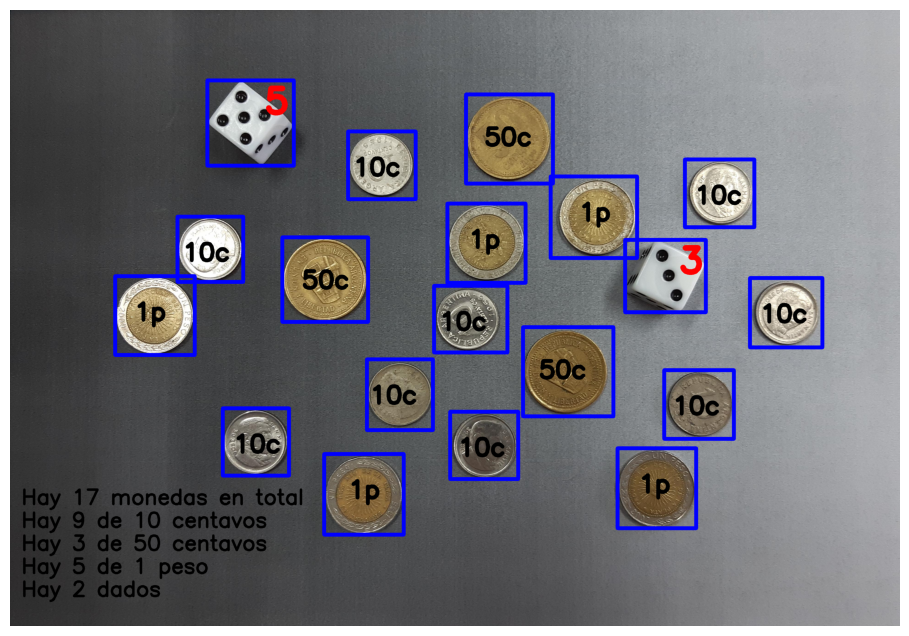

In [ ]:
#Prueba
detectar_objeto(binary_img,img)

## **Ejercicio 2**

### **Detección de patentes**

### **Item a**

In [5]:
def obtener_patentes(imagen):
  #Cargar la imagen y pasar a escala de girses
  img = cv2.imread(imagen, cv2.IMREAD_COLOR)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #Aplicar filtro Sobel
  imagen_sobel = cv2.Sobel(img_gray, cv2.CV_16S, 1, 0, ksize=1)
  imagen_sobel = cv2.convertScaleAbs(imagen_sobel)

  #Binarizar la imagen
  imagen_binaria = np.where(imagen_sobel > 108, 1, 0)
  imagen_binaria = imagen_binaria.astype(np.uint8)

  #Aplicar dilatación
  kernel = np.ones((16,16),np.uint8)
  img_dilatada = cv2.dilate(imagen_binaria,kernel,iterations=1)

  #Morfología para mejorar la segmentación obtenida
  morf = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 24))
  #Apertura para remover elementos pequeños
  imagen_apertura = cv2.morphologyEx(img_dilatada, cv2.MORPH_OPEN, morf)
  #Clausura para rellenar huecos.
  #imagen_clausura = cv2.morphologyEx(imagen_apertura, cv2.MORPH_CLOSE, morf)

  #Detección de componentes conectadas
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(imagen_apertura,8, cv2.CV_32S)

  relacion_aspecto_mayor = 0
  xx,yy,ll,hh = 0,0,0,0
  for st in stats:
    if st[4] >= 1400 and st[4] <= 7000:

      #Coordenadas de las patentes
      x, y, ancho, alto = st[0],st[1],st[2],st[3]

      #Calcular relación de aspecto
      relacion_de_aspecto = float(ancho) / alto
      if relacion_de_aspecto > relacion_aspecto_mayor:
        relacion_aspecto_mayor = relacion_de_aspecto
        xx,yy,ll,hh = x, y, ancho, alto

  #Extraer ROI usando las coordenadas de la patente
  roi = img[yy:yy+hh, xx:xx+ll]
  plt.figure(figsize=(8, 8)),plt.imshow(roi,cmap='gray'),plt.axis('off') ,plt.show();
  return roi

In [6]:
def mostrar_resultados(imagenes,f,c):
    # Configura el subplot
    fig, axs = plt.subplots(f, c, figsize=(12, 8),facecolor='#333333')
    fig.tight_layout(pad=0.5)

    # Itera sobre las imágenes y las muestra en el subplot
    for i in range(f):
        for j in range(c):
            img = imagenes[i * c + j]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')

    plt.show()

### **Item b**

In [7]:
def segmentar_patentes(patente):
  gray_roi = cv2.cvtColor(patente, cv2.COLOR_BGR2GRAY)

  #Binarizar la imagen
  imagen_binaria = np.where(gray_roi > 121, 1, 0)
  imagen_binaria = imagen_binaria.astype(np.uint8)

  # Componentes conectadas
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(imagen_binaria,8, cv2.CV_32S)
  im_color = cv2.applyColorMap(np.uint8(255/num_labels*labels), cv2.COLORMAP_JET)

  #Dibujar rectángulos
  for st in stats:
    if st[4] >= 16 and st[4] <= 100 and st[1] > 0 and st[0] > 0:
      cv2.rectangle(patente,(st[0],st[1]),(st[0]+st[2],st[1]+st[3]),color=(255,0,0),thickness=1)
  plt.imshow(patente,cmap='gray'),plt.axis('off'),plt.show();

# **Mostrar resultados:**

In [ ]:
#Cargo la ruta de las imágenes
ruta = '/content/drive/MyDrive/PI/TP-2/'

#Guardo las rutas completas
imagen_patente = [f'{ruta}img0{n}.png' if n < 10 else f'{ruta}img{n}.png' for n in range(1,13)];

#Segmento las imágenes y las guardo
patentes = [obtener_patentes(img) for img in imagen_patente];

#Segmento las patentes y las guardo
lista_patentes = [patentes[1],patentes[3],patentes[4],patentes[5],patentes[6],patentes[8],patentes[9]]
patentes_segmentadas = [segmentar_patentes(img) for img in lista_patentes];

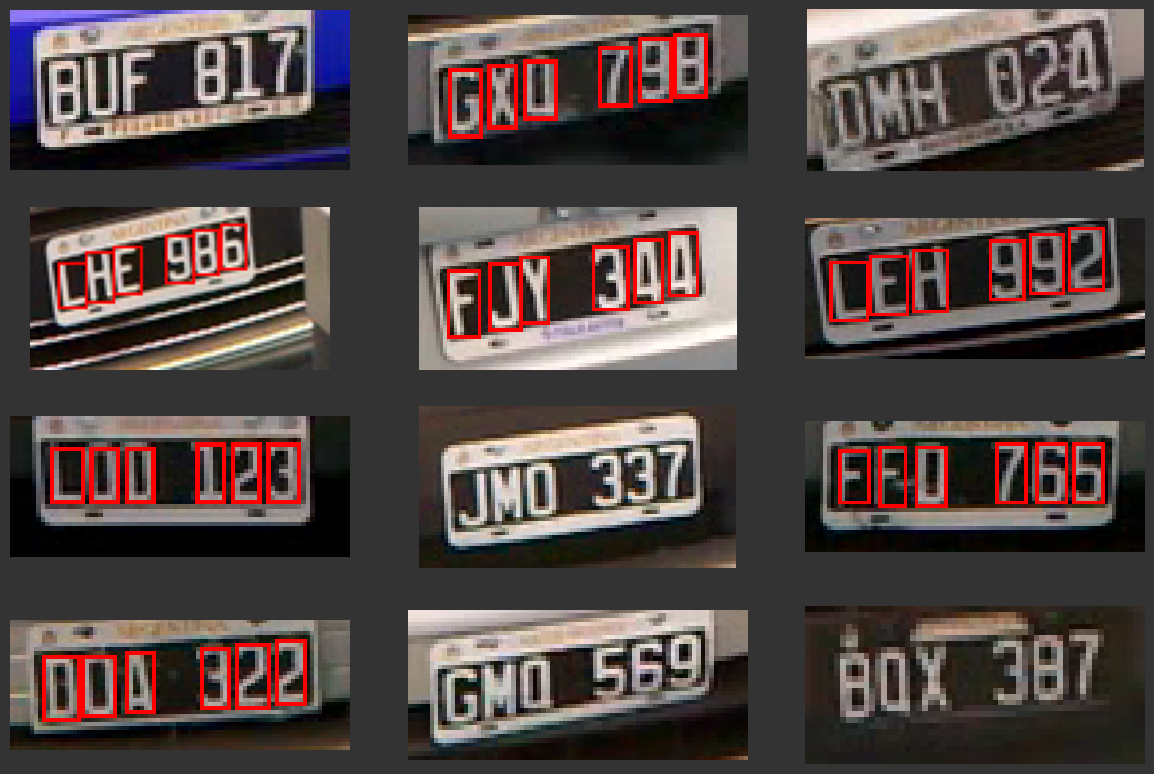

In [9]:
mostrar_resultados(patentes,4,3)